In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsRegressor

# Classe

In [2]:
class ModelCrafter:

    def __init__(self) -> None:
        
        self.models = dict()

        self.results = dict()

        self.results_per_fold = dict()

        self.kf = KFold(n_splits=5) 

    def AddModel(self, modelos : list = []) -> None:
        """Método para adicionar modelos ao objeto. A estrutura é uma lista de tuplas onde a tupla segue o seguinte esquema: (nome do modelo, modelo instanciado)"""
        
        for modelo in modelos:
            self.models[modelo[0]] = modelo[1]

    def RemoveModel(self, nome: str = None, tipo: str = None) -> None:
        """Remove modelos do objeto"""
        
        if tipo == 'all':
            self.models=dict()
            return

        del self.models[nome]

          
    def HoldOut(self,X: pd.DataFrame, y: pd.Series, pipe: Pipeline ,nome: str):
        """Treina somente um modelo dentre os que estão no objeto"""
        if nome not in self.models.keys():
            print('Modelo invalido')
            return
        
        if len(pipe.steps) > 1:
            pipe.steps.pop()
            
        pipe.steps.append((nome,self.models[nome]))

        modelo = pipe

        x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

        modelo.fit(x_train,y_train)
        predito = modelo.predict(x_test)

        aux_df = x_test.copy()
    

        return predito, y_test, aux_df

    def Validacao(self, X_train: pd.DataFrame = None, X_test: pd.DataFrame = None , y_train: pd.Series = None, y_test: pd.Series = None, pipe: Pipeline = None):
       
        if len(self.models) == 0:
            return "Nenhum modelo adicionado na estrutura"

        resultados = {'modelo':[],'mae_treino':[], 'mae_teste':[], 'rms_treino':[], 'rms_teste':[]}

        for aux in self.models.items():
            nome_modelo = aux[0]
            modelo = aux[1]

            if len(pipe.steps) > 1:
                pipe.steps.pop()

            
            print(f"-----{nome_modelo}-----")
            pipe.steps.append(("Model",modelo))
            modelo = pipe

            modelo.fit(X_train,y_train)

            pred_train = modelo.predict(X_train)
            pred_test = modelo.predict(X_test)


            mae_train  =  mean_absolute_error(y_train,pred_train)
            rms_train =  mean_squared_error(y_train,pred_train, squared = False)

            mae_test = mean_absolute_error(y_test,pred_test)
            rms_test = mean_squared_error(y_test, pred_test, squared= False)

            resultados['modelo'].append(nome_modelo)
            resultados['mae_treino'].append(mae_train)
            resultados['mae_teste'].append(mae_test)
            resultados['rms_treino'].append(rms_train)
            resultados['rms_teste'].append(rms_test)

        return pd.DataFrame(resultados)
        

    def ValidacaoCruzada(self, X: np.ndarray, y: np.array, pipe: Pipeline = None) -> None:
        """Treina todos os modelos inseridos no objeto através de validação cruzada"""
		
        if len(self.models) == 0:
            return "Nenhum modelo adicionado na estrutura"
        
        for aux in self.models.items():
            nome_modelo = aux[0]
            modelo = aux[1]

            if len(pipe.steps) > 1:
                pipe.steps.pop()

            mae = 0
            rms = 0
            
            
            resultados_aux = []

            print(f"-----{nome_modelo}-----")
            pipe.steps.append(("Model",modelo))
            modelo = pipe
            for i, (train_index, test_index) in enumerate(self.kf.split(X)):
                #print(f"Fold {i}:")
                
                #print(f"  Train: index={train_index}")
                #print(f"  Test:  index={test_index}")

                X_train = X.loc[train_index,:]
                y_train = y.loc[train_index]

                
                X_test = X.loc[test_index,:]
                y_test = y.loc[test_index]

                
                modelo.fit(X_train,y_train)

                predito = modelo.predict(X_test)
  
                
                resultados_aux.append((y_test,predito)) 
                
                mae  += mean_absolute_error(y_test,predito)
                rms += mean_squared_error(y_test,predito,squared = False)
               

                
            self.results[nome_modelo]=[mae/5, rms/5]
            self.results_per_fold[nome_modelo] = resultados_aux

        return self._gerar_resultado()

    def _gerar_resultado(self) -> None:
        """Gera os resultados em uma estrutura DataFrame"""
        
        indices = ['mae','rms']
        #display(pd.DataFrame(self.results,index=indices).T)
        return pd.DataFrame(self.results,index=indices).T

# Continuação

In [3]:
model_pipeline = Pipeline([('preprocessor',StandardScaler())])

In [4]:
modelos = [('regressao linear',LinearRegression()),
           ('ridge',Ridge()),
           ('lasso',Lasso()),
           ('knn',KNeighborsRegressor()),
           ('floresta',RandomForestRegressor(random_state = 0))]

modelcrafter = ModelCrafter()

modelcrafter.AddModel(modelos)

In [5]:
df = pd.read_csv('data.csv')

In [6]:
X = df.drop(['wavenumber','intensity','j','branch','pressure','temperature','gamma','sigma','fwhm'],axis=1)

y = df[['fwhm','gamma','sigma']]

In [7]:
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.2 , shuffle= True,random_state = 0)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [8]:
baseline = modelcrafter.ValidacaoCruzada(X_train,y_train,model_pipeline)

baseline.sort_values(by='mae',ascending=True)

-----regressao linear-----
-----ridge-----
-----lasso-----
-----knn-----
-----floresta-----


,mae,rms
regressao linear,0.004437,0.010805
ridge,0.004541,0.010711
floresta,0.005040,0.012676
knn,0.010180,0.014566
lasso,0.027228,0.039353


In [9]:
validacao = modelcrafter.Validacao(X_train,X_test,y_train,y_test,model_pipeline)

validacao.sort_values(by='mae_teste')

-----regressao linear-----
-----ridge-----
-----lasso-----
-----knn-----
-----floresta-----


,modelo,mae_treino,mae_teste,rms_treino,rms_teste
0,regressao linear,0.003708,0.005906,0.008668,0.014889
1,ridge,0.004039,0.006146,0.009053,0.015070
4,floresta,0.001990,0.006518,0.005520,0.018888
3,knn,0.007611,0.013140,0.010772,0.021725
2,lasso,0.027115,0.027672,0.039508,0.038607


In [10]:
best = modelcrafter.models['floresta']

In [11]:
model  = Pipeline([('preprocessor',StandardScaler()),('model', best)])
model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('model', RandomForestRegressor(random_state=0))])

In [12]:
pd.DataFrame(model.predict(X_test))

,0,1,2
0,0.104340,0.047489,0.011394
1,0.128968,0.058770,0.015237
2,0.069472,0.033151,0.005910
3,0.118613,0.056297,0.010413
4,0.371283,0.172394,0.039312
...,...,...,...
80,0.070208,0.033746,0.005638
81,0.115991,0.054822,0.010822
82,0.164390,0.075328,0.018301
83,0.088039,0.041166,0.008988


In [13]:
pd.DataFrame(model.predict(X))

,0,1,2
0,0.068381,0.032885,0.005345
1,0.079897,0.038020,0.006902
2,0.080474,0.038921,0.005714
3,0.079721,0.038305,0.006192
4,0.070280,0.033374,0.006253
...,...,...,...
416,0.127947,0.059425,0.013638
417,0.115147,0.054488,0.010856
418,0.099428,0.045467,0.011553
419,0.194318,0.089155,0.020797


In [14]:
y['fwhm_pred'] = pd.DataFrame(model.predict(X))[0]

/tmp/ipykernel_28976/2371600976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['fwhm_pred'] = pd.DataFrame(model.predict(X))[0]


In [17]:
df['fwhm_pred'] = pd.DataFrame(model.predict(X))[0]
df['gamma_pred'] = pd.DataFrame(model.predict(X))[1]
df['sigma_pred'] = pd.DataFrame(model.predict(X))[2]

In [18]:
df.columns

Index(['wavenumber', 'intensity', 'j', 'branch', 'pressure', 'temperature',
       'fwhm', 'gamma', 'sigma', 'height', 'mean_wv', 'std_wv', 'skew_wv',
       'kurtosis_wv', 'max_wv', 'min_wv', 'median_wv', 'mean_int', 'std_int',
       'skew_int', 'kurtosis_int', 'max_int', 'min_int', 'median_int',
       'fwhm_pred', 'gamma_pred', 'sigma_pred'],
      dtype='object')

In [19]:
val =df[['wavenumber','intensity','j','branch','temperature','pressure','fwhm','fwhm_pred','gamma','gamma_pred','sigma','sigma_pred','height']]

In [20]:
val.query('j == 0 and branch == "R35"')

,wavenumber,intensity,j,branch,temperature,pressure,fwhm,fwhm_pred,gamma,gamma_pred,sigma,sigma_pred,height
10,5687.65090,1.59091,0,R35,293,145,0.089231,0.088746,0.043027,0.041163,0.006907,0.009560,1.600791
36,5687.65090,1.55898,0,R35,293,78,0.050596,0.051597,0.021738,0.022325,0.007816,0.007584,1.565409
80,5687.65184,1.59502,0,R35,293,200,0.121214,0.120825,0.058869,0.057277,0.008418,0.010648,1.605912
115,5687.64619,1.47811,0,R35,293,790,0.330483,0.322996,0.160957,0.157778,0.021823,0.019230,1.481029
136,5687.65184,1.44966,0,R35,293,398,0.198544,0.200518,0.098885,0.099215,0.005077,0.007256,1.447685
168,5687.63869,1.34859,0,R35,313,141,0.071036,0.071189,0.034348,0.034248,0.005289,0.005647,1.336585
200,5687.63680,0.29181,0,R35,313,27,0.040356,0.040119,0.009662,0.009644,0.012165,0.012070,0.298989
227,5687.63869,1.04618,0,R35,313,211,0.150549,0.152968,0.071142,0.072135,0.014482,0.014561,1.017198
258,5687.63680,0.60712,0,R35,313,76,0.074803,0.076783,0.035055,0.035228,0.007694,0.008808,0.598391
296,5687.63869,1.54374,0,R35,315,181,0.068370,0.068430,0.032712,0.032767,0.005824,0.005751,1.528490


In [21]:
from scipy.special import voigt_profile

In [22]:
def separa_pontos_manual(intensidade_relativa = 0.1,centro = 0,linha = 0, spec_mensurado = None):

    #global x_espec,y_espec

    #linha = lines[id].tolist()

    #centro = float(linha[2])

    x_espec = list(spec_mensurado['wavenumber'])
    y_espec = list(spec_mensurado['intensity'])
    

    pontosx = []
    pontosy = []

    # intensidade do centro e dos pontos adjacentes
    icentro = float(linha)
    iponto = float(linha)# só inicializando a variável, preciso disso para entrar no while (1 > intensidade_relativa)

    esquerda_x = []
    esquerda_y = []

    direita_x = []
    direita_y = []


    i = 1

    # para a esquerda
    while (iponto / icentro >= intensidade_relativa):


        # aqui é de fato o valor da intensidade dos pontos adjacentes
        iponto = y_espec[y_espec.index(icentro) - i]



        if iponto / icentro >= intensidade_relativa:
            esquerda_x.insert(-i, x_espec[x_espec.index(centro) - i])
            esquerda_y.insert(-i, y_espec[y_espec.index(icentro) - i])


        i = i + 1

    # Para direita

    icentro = float(linha)
    iponto  = float(linha)
    i = 1
    while (iponto / icentro >= intensidade_relativa):

        iponto = y_espec[y_espec.index(icentro) + i]


        if iponto / icentro >= intensidade_relativa:
            direita_x.insert(i, x_espec[x_espec.index(centro) + i])
            direita_y.insert(i, y_espec[y_espec.index(icentro) + i])


        i = i + 1

    pontos_x = esquerda_x + [centro] + direita_x

    pontos_y = esquerda_y + [icentro] + direita_y

   

    return pd.DataFrame({'wavenumber':pontos_x, 'intensity':pontos_y})

In [23]:
spec = pd.read_csv('/home/alexandre/Área de Trabalho/ic/Espectros para os ajustes/20°C/hcl_20_20c_145mbar.csv')
spec.columns = ['wavenumber','intensity']
x = separa_pontos_manual(intensidade_relativa = 0.3,centro = 5687.65090,linha = 1.59091, spec_mensurado = spec)

In [32]:
sigma = 0.009513  # Parâmetro da Gaussiana
gamma = 0.041128  # Parâmetro da Lorentziana
voigt_result = 0.215*voigt_profile(x['wavenumber'] - 5687.65090, sigma, gamma)

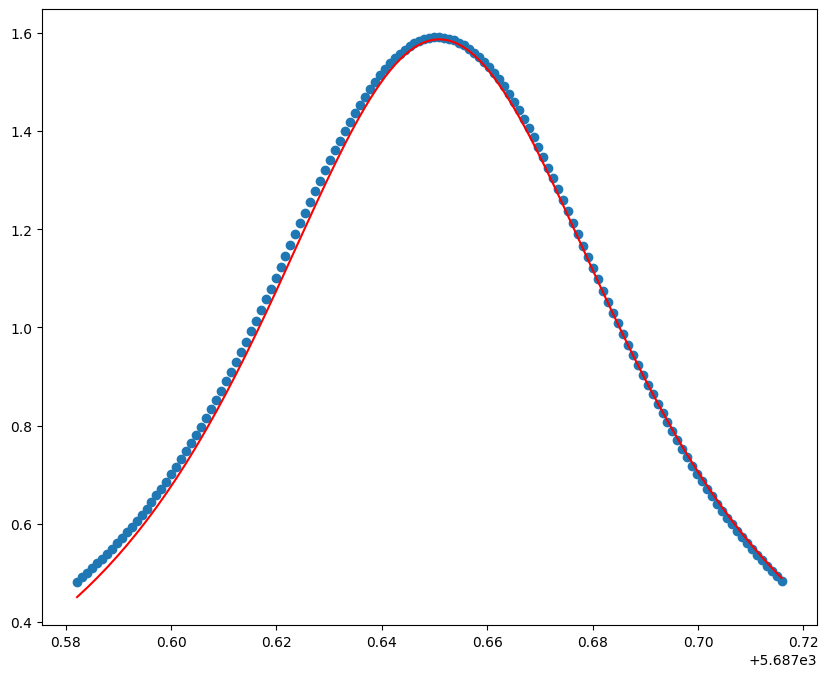

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.scatter(x= x['wavenumber'],y = x['intensity'])
plt.plot(x['wavenumber'] , voigt_result,c='r',linewidth=1.5)